In [1]:
# https://github.com/higgsfield/RL-Adventure/

In [2]:
%matplotlib inline

In [3]:
import yaml
import datetime

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [4]:
import math
import os 
import random 
import numpy as np 

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

In [5]:
seed_value = 324267*2# sys.argv[1]

os.environ['PYTHONHASHSEED']=str(seed_value) 
random.seed(seed_value) 
np.random.seed(seed_value) 
torch.manual_seed(seed_value)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
import gym
# CartPole-v0 Environment
env_id = "CartPole-v0"
env = gym.make(env_id)
env.seed(seed_value);

In [7]:
class DQN(nn.Module): #base model
    def __init__(self, num_inputs, num_actions, HIDDEN_LAYER_WIDTH):
        super(DQN, self).__init__()
        
        self.action_dim = num_actions
        
        self.layers = nn.Sequential(
            nn.Linear(num_inputs, HIDDEN_LAYER_WIDTH),
            nn.ReLU(),
            nn.Linear(HIDDEN_LAYER_WIDTH, HIDDEN_LAYER_WIDTH),
            nn.ReLU(),
            nn.Linear(HIDDEN_LAYER_WIDTH, num_actions)
        )

    def forward(self, x):
        return self.layers(x)
    
def get_action(policy_net, device, state, epsilon):
    with torch.no_grad():
        if random.random() > epsilon:
            state   = torch.FloatTensor(state).unsqueeze(dim=0).to(device)
            q_values = policy_net(state)
            action  = q_values.max(dim=1)[1].item()
        else:
            action = random.randrange(self.action_dim)
    return action

In [8]:
class DuelingDQN(nn.Module):
    def __init__(self, num_inputs, num_actions, HIDDEN_LAYER_WIDTH):
        super(DuelingDQN, self).__init__()
        self.action_dim = num_actions
        
        self.feature = nn.Sequential(
            nn.Linear(num_inputs, 128),
            nn.ReLU()
        )
        
        self.advantage = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_actions)
        )
        
        self.value = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
    def forward(self, x):
        x = self.feature(x)
        advantage = self.advantage(x)
        value     = self.value(x)
        return value + advantage  - advantage.mean()
    
#     def act(self, state, epsilon):
#         with torch.no_grad():
#             if random.random() > epsilon:
#                 state   = torch.FloatTensor(state).unsqueeze(dim=0).to(self.device)
#                 q_values = self.forward(state)
#                 action  = q_values.max(dim=1)[1].item()
#             else:
#                 action = random.randrange(self.action_dim)
#         return action

In [9]:
def greedy_play(log_name, EPISODES = 200, render = False):
    experiment = log_name.split('_')[0]

    # FROM CONFIG FILE
    config_path =  './configs/' + experiment + '.yaml' # sys.argv[2]
    config = yaml.safe_load(open(config_path,'r'))

    USE_GPU = config['USE_GPU']
    # Use CUDA
    USE_CUDA = torch.cuda.is_available() and USE_GPU

    if USE_CUDA:
        torch.cuda.manual_seed(seed_value)
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    # MODEL
    if (config['MODEL_NAME']=='D1QN' or config['MODEL_NAME']=='DQN' or config['MODEL_NAME']=='D2QN'):
        # only one NN for estimating Q-values
        policy_net = DQN(env.observation_space.shape[0], 
                     env.action_space.n,
                     config['HIDDEN_LAYER_WIDTH'])
        policy_net = policy_net.to(device)


    elif (config['MODEL_NAME']=='DuDQN' or config['MODEL_NAME']=='DuD2QN'):
        # one policy_net and one target_net
        policy_net = DuelingDQN(env.observation_space.shape[0], 
                     env.action_space.n,
                     config['HIDDEN_LAYER_WIDTH'])
        
        policy_net = policy_net.to(device)

    else: #default policy_net is D1QN
        # only one NN for estimating Q-values
        policy_net = DQN(env.observation_space.shape[0], 
                     env.action_space.n,
                     config['HIDDEN_LAYER_WIDTH'])
        
        policy_net = policy_net.to(device)

    # # Load Learned Model Parameters
    MODEL_FILE = './models/'+ log_name + '.pth'
    policy_net.load_state_dict(torch.load(MODEL_FILE));
    policy_net.eval();


    # ROLLOUT
    all_rewards = []

    for ep in range(EPISODES):
        episode_reward = 0
        done = False
        state = env.reset()
#         #random initial location
#         env.reset()
#         env.state[0] = np.random.uniform(low=-2.0,high=2.0)
#         state = env.state
        while not done:
            if render:
                env.render()
            action = get_action(policy_net, device, state, epsilon=0.0)
            next_state, reward, done, _ = env.step(action)
            state = next_state
            episode_reward += reward
        if render: 
            print("EP: ", ep, "\tRWD: ", episode_reward)
        all_rewards.append(episode_reward)

    return [experiment, all_rewards]

env.close()

In [10]:
exp_list = ['D1QN_D1QN_Naive_1000_freq_100_324267_04171400',
'D1QN-PER_D1QN_NaivePER_1000_freq_100_324267_04164957',
'DQN_DQN_Naive_1000_freq_100_324267_04171233',
'DQN-PER_DQN_NaivePER_1000_freq_100_324267_04164826',
'DQN-PER-original_DQN_NaivePER_100000_freq_1000_324267_04163756',

'D2QN_D2QN_Naive_1000_freq_100_324267_04170846',
'D2QN-PER_D2QN_NaivePER_1000_freq_100_324267_04165444',

'DuDQN_DuDQN_Naive_1000_freq_100_324267_04170649',
'DuDQN-PER_DuDQN_NaivePER_1000_freq_100_324267_04165300',

'DuD2QN_DuD2QN_Naive_1000_freq_100_324267_04170223',
'DuD2QN-PER_DuD2QN_NaivePER_1000_freq_100_324267_04165910']

In [11]:
exp_dict = {}
for exp in exp_list:
    experiment = exp.split('_')[0]
    exp_dict[experiment] = exp

In [12]:
all_results = []
for exp in exp_list:
    all_results.append(greedy_play(log_name=exp,
                                   EPISODES=200, 
                                   render=False))

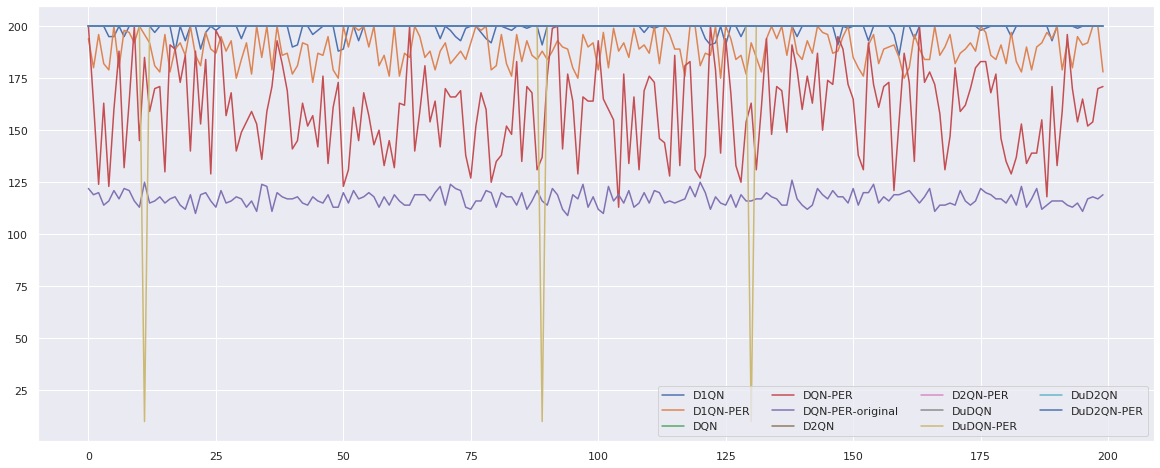

In [13]:
fig = plt.figure(figsize=(20,8))
for exp, results in all_results:
    plt.plot(results, label=exp)
plt.legend(ncol=4, loc ="lower right")
plt.savefig('comparative_scores.png',
            dpi=300, 
            format='png')

In [14]:
# exp = exp_dict['DuD2QN']
# greedy_play(exp, 5, render=True );
# env.close()

In [15]:
env.close()